In [1]:
!pip install keras

In [3]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, Dropout, BatchNormalization
from keras.layers import LeakyReLU
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report


In [4]:
# Load the dataset
data = pd.read_csv('/content/sample_data/cicddos2019_dataset.csv')

# Select relevant features and drop unnecessary columns (like IP addresses, ports, etc.)
# Here, replace with actual relevant feature columns from your dataset
data = data.drop(columns=['Flow ID', 'Source IP', 'Destination IP', 'Timestamp', 'Label'], errors='ignore')

# data["Class"]
# Label Encoding: Convert BENIGN and DDoS into binary labels (0 for BENIGN, 1 for DDoS)
labels = (data['Class'] != 'Benign').astype(int)  # DDoS = 1, BENIGN = 0

data["Labels"] = labels

# Drop the Label column after encoding
data = data.drop(columns=['Class'], errors='ignore')


# Handle missing values by replacing them with zeros
data.fillna(0, inplace=True)

# Normalize the dataset using MinMaxScaler
scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(data)

# Split the data into normal (BENIGN) and DDoS attack data
X_normal = data_scaled[labels == 0]
X_ddos = data_scaled[labels == 1]

print(len(X_normal))
print(len(X_ddos))

# Train-test split (Train the model only on normal traffic data)
X_train, X_test = train_test_split(X_normal, test_size=0.2, random_state=42)


97831
333540


In [5]:
# Build an Autoencoder model
input_dim = X_train.shape[1]  # Number of features
encoding_dim = 32  # Size of encoded layer

autoencoder = Sequential()
# Encoder
autoencoder.add(Dense(encoding_dim, input_shape=(input_dim,)))
autoencoder.add(LeakyReLU(alpha=0.2))
autoencoder.add(BatchNormalization())
autoencoder.add(Dense(int(encoding_dim / 2)))
autoencoder.add(LeakyReLU(alpha=0.2))
autoencoder.add(BatchNormalization())

# Bottleneck
autoencoder.add(Dense(int(encoding_dim / 4)))
autoencoder.add(LeakyReLU(alpha=0.2))
autoencoder.add(Dropout(0.2))

# Decoder
autoencoder.add(Dense(int(encoding_dim / 2)))
autoencoder.add(LeakyReLU(alpha=0.2))
autoencoder.add(BatchNormalization())
autoencoder.add(Dense(encoding_dim))
autoencoder.add(LeakyReLU(alpha=0.2))
autoencoder.add(BatchNormalization())
autoencoder.add(Dense(input_dim, activation='sigmoid'))

autoencoder.compile(optimizer='adam', loss='mean_squared_error')

# Implement early stopping and reduce learning rate on plateau
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-5)


# Train the autoencoder
history = autoencoder.fit(X_train, X_train, epochs=50, batch_size=32, validation_split=0.2, shuffle=True)



/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Epoch 1/50
1957/1957 ━━━━━━━━━━━━━━━━━━━━ 15s 5ms/step - loss: 0.0619 - val_loss: 0.0017
Epoch 2/50
1957/1957 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 0.0026 - val_loss: 0.0013
Epoch 3/50
1957/1957 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - loss: 0.0020 - val_loss: 9.7872e-04
Epoch 4/50
1957/1957 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - loss: 0.0019 - val_loss: 8.9334e-04
Epoch 5/50
1957/1957 ━━━━━━━━━━━━━━━━━━━━ 15s 6ms/step - loss: 0.0017 - val_loss: 8.1467e-04
Epoch 6/50
1957/1957 ━━━━━━━━━━━━━━━━━━━━ 15s 3ms/step - loss: 0.0017 - val_loss: 8.0144e-04
Epoch 7/50
1957/1957 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - loss: 0.0016 - val_loss: 7.3418e-04
Epoch 8/50
1957/1957 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - loss: 0.0015 - val_loss: 7.2585e-04
Epoch 9/50
1957/1957 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - loss: 0.0015 - val_loss: 6.8100e-04
Epoch 10/50
1957/1957 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - loss: 0.0015 - val_loss: 6.3987e-04
Epoch 11/50
1957/1957 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.0015 - val_loss: 6

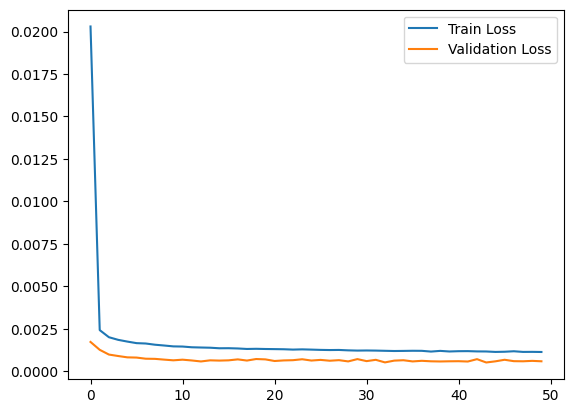

In [6]:
# Plot training vs validation loss
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.show()

In [7]:
# Reconstruct the test data
X_test_pred = autoencoder.predict(X_test)
X_test_mse = np.mean(np.power(X_test - X_test_pred, 2), axis=1)

# Set a dynamic threshold using a validation set
threshold = np.percentile(X_test_mse, 95)
print(f"Reconstruction error threshold: {threshold}")

# Evaluate on DDoS data
X_ddos_pred = autoencoder.predict(X_ddos)
X_ddos_mse = np.mean(np.power(X_ddos - X_ddos_pred, 2), axis=1)

# Classification based on reconstruction error
y_test_pred = X_test_mse > threshold
y_ddos_pred = X_ddos_mse > threshold

# Print accuracy
print(f"Normal Traffic Detection Accuracy: {100 - np.mean(y_test_pred) * 100:.2f}%")
print(f"DDoS Attack Detection Accuracy: {np.mean(y_ddos_pred) * 100:.2f}%")

# Classification report
y_true = np.concatenate([np.zeros(len(X_test)), np.ones(len(X_ddos))])
y_pred = np.concatenate([y_test_pred, y_ddos_pred])

print(classification_report(y_true, y_pred, target_names=["BENIGN", "DDoS"]))

612/612 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
Reconstruction error threshold: 0.0027356755794976165
10424/10424 ━━━━━━━━━━━━━━━━━━━━ 16s 2ms/step
Normal Traffic Detection Accuracy: 95.00%
DDoS Attack Detection Accuracy: 100.00%
              precision    recall  f1-score   support

      BENIGN       1.00      0.95      0.97     19567
        DDoS       1.00      1.00      1.00    333540

    accuracy                           1.00    353107
   macro avg       1.00      0.97      0.99    353107
weighted avg       1.00      1.00      1.00    353107

